In [309]:
import folktables
from folktables import ACSDataSource
import numpy as np

np.random.seed(0)
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df
ACSEmployment = folktables.BasicProblem(
    features=[
       'AGEP', #age; for range of values of features please check Appendix B.4 of
           #Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
       'SCHL', #educational attainment
       'MAR', #marital status
       'RELP', #relationship
       'DIS', #disability recode
       'ESP', #employment status of parents
       'CIT', #citizenship status
       'MIG', #mobility status (lived here 1 year ago)
       'MIL', #military service
       'ANC', #ancestry recode
       'NATIVITY', #nativity
       'DEAR', #hearing difficulty
       'DEYE', #vision difficulty
       'DREM', #cognitive difficulty
       'SEX', #sex
       'RAC1P', #recoded detailed race code
       'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [310]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

/Users/Kotsi/Desktop/AI_Imperial/Ethics/Fairness-ML/my_env/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


### Task 1(a) - Split data

In [311]:
data_size = data_for_aif.features.shape[0]
train, test = data_for_aif.split([0.7], shuffle=True)
splits = []
for _ in range(5):
    train, val = train.split([0.8], shuffle=True)
    splits.append((train, val))

### Task 1(b) - Model selection

In [312]:
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression


def find_most_accurate_logistic_reg_model(splits, parameters, reweighing=False):
    mean_accuracies = []
    final_scaler = None
    max_accuracy = -float('inf')
    best_model = None
    for parameter in parameters:
        accuracies = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)   
            predictions = learner.predict(X_val)
            accuracy = sum((predictions==y_val) / len(y_val))
            accuracies.append(accuracy)
        mean_accuracy = sum(accuracies) / len(accuracies)
        #print(mean_accuracy)
        mean_accuracies.append(mean_accuracy)
        if mean_accuracy > max_accuracy:
            max_accuracy = mean_accuracy
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_accuracy, parameters, mean_accuracies



In [313]:
parameters = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters)

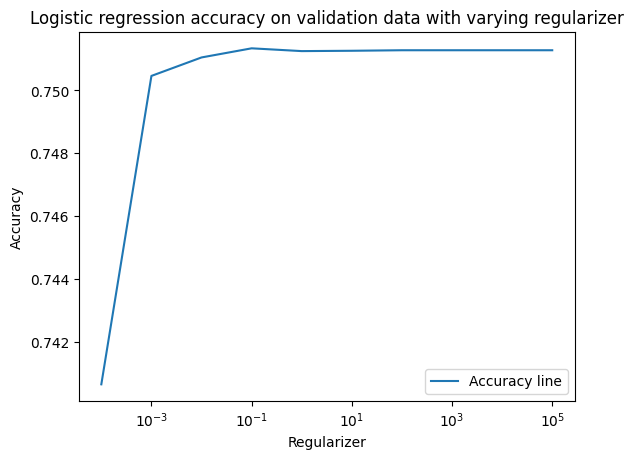

In [314]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')

plt.title('Logistic regression accuracy on validation data with varying regularizer')        
plt.xlabel('Regularizer')     
plt.ylabel('Accuracy')     

plt.legend()

plt.show()

In [315]:
print(f"Final Model: {final_model}\n")
print(f"Final Scaler: {final_scaler}\n")
print(f"Final Mean Accuracy on Val data : {final_accuracy}")

Final Model: LogisticRegression(C=0.1, random_state=1, solver='liblinear')

Final Scaler: StandardScaler()

Final Mean Accuracy on Val data : 0.751333899988068


### Test the final model on test data

In [316]:
from aif360.metrics import ClassificationMetric

def test_model_on_unseen_data(final_scaler, test, final_model, unprivileged_groups, privileged_groups):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return test_accuracy, eq_opp_diff

In [317]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [318]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7534268409311323

Fairness on test data using the equal opportunity difference metric: 0.6253460276847063


### Task(c) - Model selection based on fairness

In [319]:
def find_most_fair_logistic_reg_model(splits, parameters, reweighing=False):
    mean_fearnesses = []
    mean_fairnesses_abs = []
    final_scaler = None
    min_diff = float('inf')
    best_model = None
    for parameter in parameters:
        fairnesses = []
        fairnesses_abs = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness = metric.equal_opportunity_difference()
            fairnesses.append(fairness)
            fairness_abs = abs(metric.equal_opportunity_difference())
            fairnesses_abs.append(fairness_abs)
        mean_fairness = sum(fairnesses) / len(fairnesses)
        mean_fearnesses.append(mean_fairness)
        mean_fairness_abs = sum(fairnesses_abs) / len(fairnesses_abs)
        mean_fairnesses_abs.append(mean_fairness_abs)
        #print(mean_fairness)
        if mean_fairness_abs < min_diff:
            min_diff = mean_fairness_abs
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, min_diff, parameters, mean_fairnesses_abs, mean_fearnesses

In [320]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses = find_most_fair_logistic_reg_model(splits = splits, parameters=parameters)

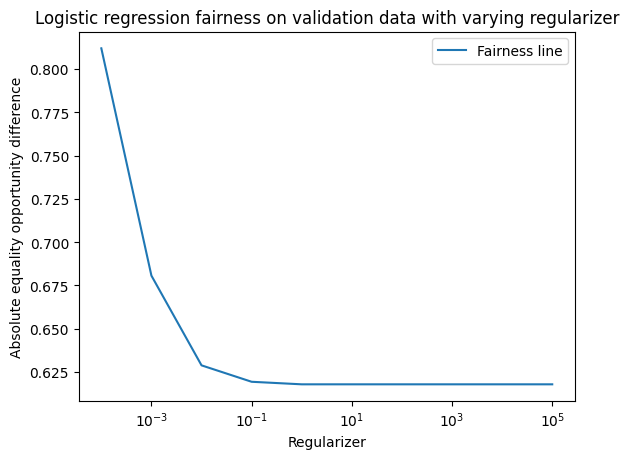

In [321]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_fairnesses_abs, label='Fairness line') 
plt.xscale('log')

plt.title('Logistic regression fairness on validation data with varying regularizer')        
plt.xlabel('Regularizer')     
plt.ylabel('Absolute equality opportunity difference')     

plt.legend()

plt.show()

### Test the final model on test data

In [322]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [323]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7531678355119419

Fairness on test data using the equal opportunity difference metric: 0.6227677730313754


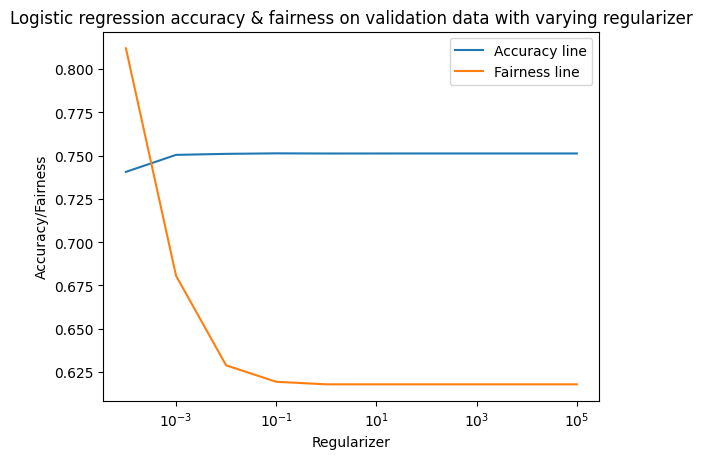

In [324]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses, label='Fairness line')
plt.xscale('log')

plt.title('Logistic regression accuracy & fairness on validation data with varying regularizer')        
plt.xlabel('Regularizer')     
plt.ylabel('Accuracy/Fairness')     

plt.legend()

plt.show()

### Task 2(a) - Select the most accurate model after reweighing

In [325]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

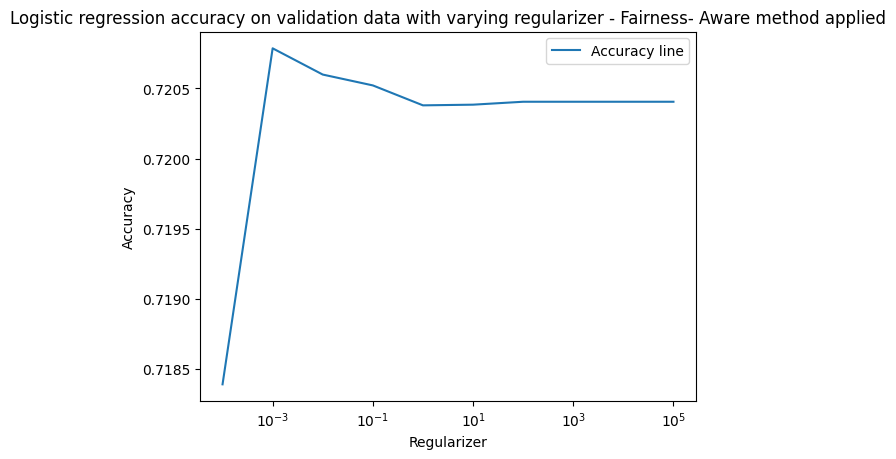

In [326]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')

plt.title('Logistic regression accuracy on validation data with varying regularizer - Fairness- Aware method applied')        
plt.xlabel('Regularizer')     
plt.ylabel('Accuracy')     

plt.legend()

plt.show()

### Test the most accurate model after reweighting on the test data

In [327]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [328]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7202143767934045

Fairness on test data using the equal opportunity difference metric: 0.018399325005312384


### Task 2(b) - Select the most fair model after reweighing

In [329]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses= find_most_fair_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)


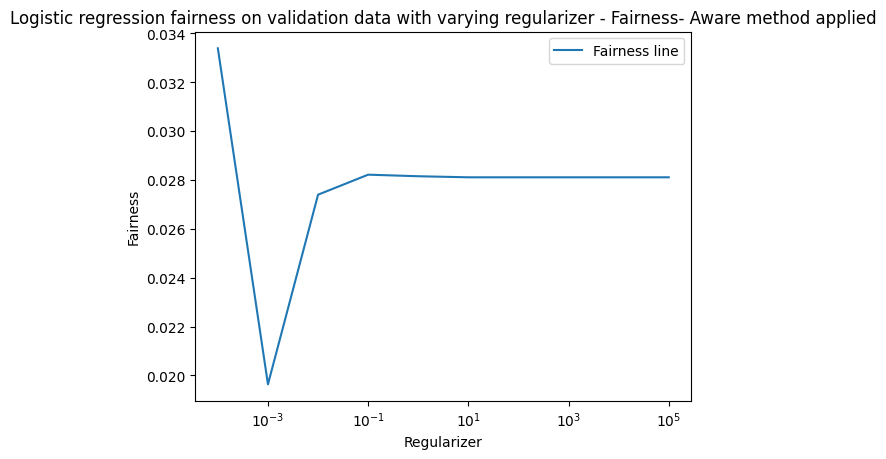

In [330]:
plt.plot(parameters, mean_fairnesses_abs, label='Fairness line') 
plt.xscale('log')

plt.title('Logistic regression fairness on validation data with varying regularizer - Fairness- Aware method applied')        
plt.xlabel('Regularizer')     
plt.ylabel('Fairness')     

plt.legend()

plt.show()

### Test the most fair model after reweighting on the test data

In [331]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [332]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7202143767934045

Fairness on test data using the equal opportunity difference metric: 0.018399325005312384


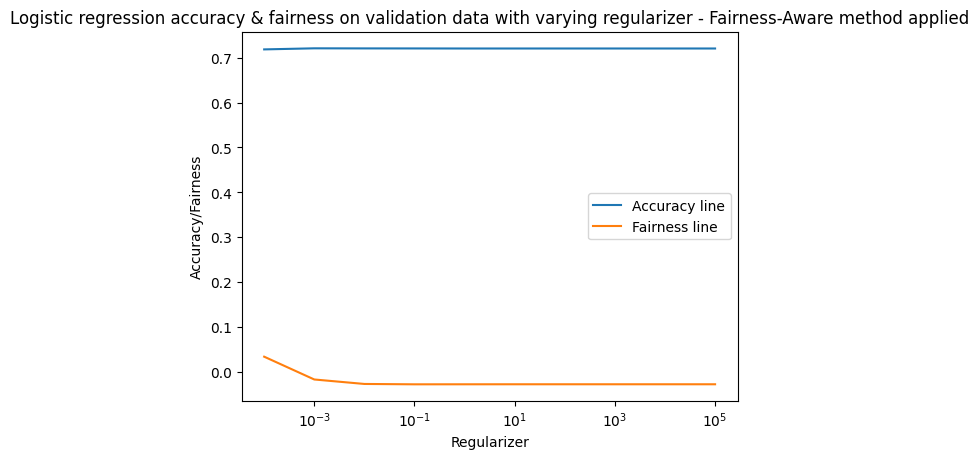

In [333]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses, label='Fairness line')
plt.xscale('log')

plt.title('Logistic regression accuracy & fairness on validation data with varying regularizer - Fairness-Aware method applied')        
plt.xlabel('Regularizer')     
plt.ylabel('Accuracy/Fairness')     

plt.legend()

plt.show()

### Task 3(a) Find best standard model

In [334]:
def find_best_model(splits, parameters, reweighing=False, accuracy_weight=0.5, fairness_weight=0.5):
    mean_combined_metrics = []
    final_scaler = None
    max_ = -float('inf')
    best_model = None
    for parameter in parameters:
        combined_metrics = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)

            accuracy = sum((predictions == y_val) / len(y_val) )
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness_abs = abs(metric.equal_opportunity_difference())
            combined_metric = accuracy_weight * accuracy + fairness_weight * (1 - fairness_abs)
            combined_metrics.append(combined_metric)
        mean_combined_metric = sum(combined_metrics) / len(combined_metrics)
        mean_combined_metrics.append(mean_combined_metric)
        #print(mean_fairness)
        if mean_combined_metric > max_:
            max_ = mean_combined_metric
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight

In [335]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters)

In [336]:
final_model, max_

(LogisticRegression(C=100, random_state=1, solver='liblinear'),
 0.5666823225081382)

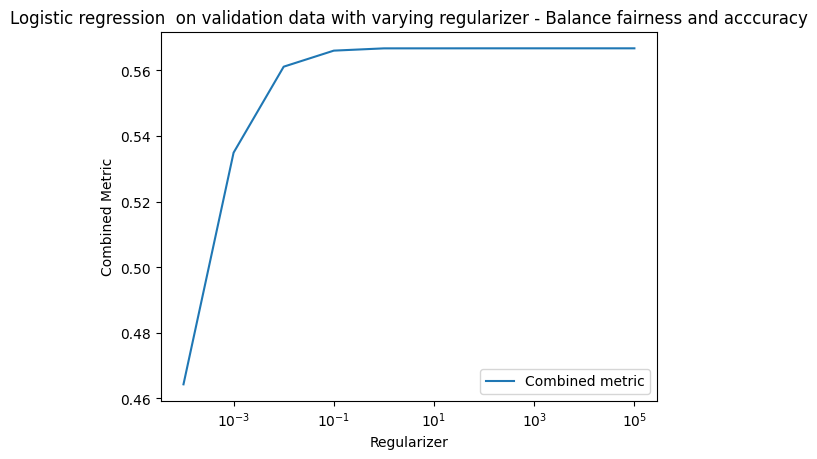

In [337]:
plt.plot(parameters, mean_combined_metrics, label='Combined metric') 
plt.xscale('log')

plt.title('Logistic regression  on validation data with varying regularizer - Balance fairness and acccuracy')        
plt.xlabel('Regularizer')     
plt.ylabel('Combined Metric')     

plt.legend()

plt.show()

In [338]:
def test_model_on_unseen_data_weighted(final_scaler, test, final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, accuracy_weight=accuracy_weight, fairness_weight=fairness_weight):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = abs(metric.equal_opportunity_difference())
    
    combined_metric = accuracy_weight * test_accuracy + fairness_weight * (1-eq_opp_diff)

    return combined_metric


In [339]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [340]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.5651898674035333


### Task 3(b)

In [341]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters, reweighing=True)

In [342]:
final_model, max_

(LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 0.8505743648536331)

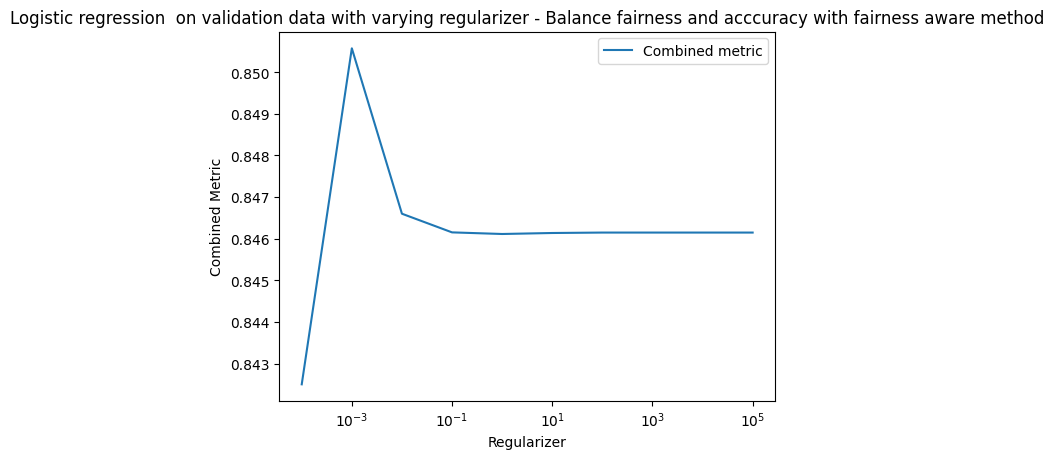

In [343]:
plt.plot(parameters, mean_combined_metrics, label='Combined metric') 
plt.xscale('log')

plt.title('Logistic regression  on validation data with varying regularizer - Balance fairness and acccuracy with fairness aware method')        
plt.xlabel('Regularizer')     
plt.ylabel('Combined Metric')     

plt.legend()

plt.show()

In [344]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model)

In [345]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.8509075258940461
